In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import json
import itertools
import cudf

from tqdm import tqdm
#from multiprocessing import Pool

counter = 0

joint_codes = {
"EW24": "NS1",
"CC1": "NS24",
"NE6": "NS24",
"EW13" : "NS25",
"EW14": "NS26",
"DT15": "CC4",
"STC": "NE16",
"PTC": "NE17"
}

interchange_codes = {
    "BP1": "NS4",
    "CC15": "NS17",
    "CE2": "NS27",
    "CC9": "EW8",
    "DT14": "EW12",
    "NE3": "EW16",
    "CC22": "EW21",
    "DT35": "CG1",
    "CC29": "NE1",
    "DT19": "NE4",
    "DT12": "NE7",
    "CC13": "NE12",
    "STC": "NE16",
    "PTC": "NE17",
    "DT26": "CC10",
    "DT9": "CC19",
    "DT16": "CE1",
    "TE2": "NS9",
    "TE9": "CC17",
    "TE11": "DT10",
    "TE14": "NS22",
    "TE17": "EW16",
    "TE20": "NS27",
    "TE31": "DT37",
    "FL1": "CC32",
    "JS1": "NS4",
    "JS8": "EW27",
    "JE5": "EW24-NS1",
    "CR5": "EW1",
    "CR8": "NE14",
    "CR11": "NS16",
    "CR13": "TE7",
	"CP4": "NE17",
    #unpaid links
    "BP6": "DT1",
    "PB6": "DT1", # silly HSO intern
    "DT32": "EW2",
    "DT11": "NS21",
    "CP3": "PE4"
    
    }

def replace_jointcode(code):
  code = code.split('/')[0]
  if code in joint_codes.keys():
    return joint_codes[code]
  if code in interchange_codes.keys():
    return interchange_codes[code]
  return code
  
#http://www.racketracer.com/2016/07/06/pandas-in-parallel/

# def parallelize_dataframe(df, func):
    # df_split = np.array_split(df, num_partitions)
    # pool = Pool(num_cores)
    # df = pd.concat(pool.map(func, df_split))
    # pool.close()
    # pool.join()
    # return df

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return list(a), list(b)
    
def unpack_column(data_row):
  global df_fin
  global df_temp
  global counter
  
  orig = replace_jointcode(data_row["ORIGIN_PT_CODE"])
  dest = replace_jointcode(data_row["DESTINATION_PT_CODE"])
  a, b = pairwise(data[orig][dest])
  a.pop()
  pairs_len = len(b)
  df_data = pd.DataFrame([data_row])
  df_data = df_data.loc[df_data.index.repeat(pairs_len)]
  df_data["ORIGIN_PT_CODE"] = a
  df_data["DESTINATION_PT_CODE"] = b
  if len(df_data.index) > 0:
     df_temp = pd.concat([df_temp, df_data])
     #make sure df_temp doesn't get too big
     counter = counter + 1
     if counter > 500:
        #df_temp = df_temp.groupby(['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TIME_PER_HOUR']).sum()
        df_fin = df_fin.append(cudf.DataFrame.from_pandas(df_temp))
        #df_fin = df_fin.append(df_temp)
        df_temp = pd.DataFrame()
        counter = 0

month = input("Dataset for (YYYYMM): ")
weekdays = input("Number of weekdays: ")
weekdays = int(weekdays)

specials = input("Number of weekends and holidays: ")
specials = int(specials)

total = specials + weekdays

#now for orig dest

in_file = os.path.join(os.getcwd(), "..", "raw_data", month, "origin_destination_train_" + month + ".csv")

df = pd.read_csv(in_file)

#orig dest
df['multiplier'] = df['DAY_TYPE']

df = df.replace({'ORIGIN_PT_CODE': interchange_codes, 'DESTINATION_PT_CODE': interchange_codes, 'multiplier': {'WEEKENDS/HOLIDAY': specials, 'WEEKDAY': weekdays}})
df['TOTAL_TRIPS'] = (df['TOTAL_TRIPS'] / df['multiplier']).round(0)
df = df[df['TOTAL_TRIPS'] !=0]
df = df[df['ORIGIN_PT_CODE'] != df['DESTINATION_PT_CODE']]
df1 = df.drop(columns=['multiplier'])

#congestion analysis
with open('train_routes_nx.json') as json_file:
    data = json.load(json_file)
    
tqdm.pandas()

df_fin = cudf.DataFrame()
df_temp = pd.DataFrame()
df1.progress_apply(unpack_column, axis=1)

#pack up the stragglers
#df_temp = df_temp.groupby(['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TIME_PER_HOUR']).sum()
df_fin = df_fin.append(cudf.DataFrame.from_pandas(df_temp))
#df_fin = df_fin.append(df_temp)

df_fin = df_fin.groupby(['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TIME_PER_HOUR']).sum()

df_fin = df_fin.to_pandas()

df_graphs = df_fin

#copy out, for graph generation

df_fin1 = pd.pivot_table(df_fin, index=['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'], columns=["TIME_PER_HOUR"], aggfunc={'TOTAL_TRIPS': np.sum})

df_fin = df_fin.groupby(['DAY_TYPE', 'ORIGIN_PT_CODE', 'DESTINATION_PT_CODE']).sum()

Dataset for (YYYYMM): 202106
Number of weekdays: 22
Number of weekends and holidays: 8


100%|██████████| 327603/327603 [08:27<00:00, 646.02it/s]


In [2]:
df_fin1

TOTAL_TRIPS                \
TIME_PER_HOUR                                                0      5      6    
DAY_TYPE         ORIGIN_PT_CODE DESTINATION_PT_CODE                             
WEEKDAY          BP10           BP11                        NaN  134.0  311.0   
                                BP9                         NaN   55.0   82.0   
                 BP11           BP10                        NaN   31.0   53.0   
                                BP12                        NaN  279.0  623.0   
                 BP12           BP11                        NaN   20.0   55.0   
...                                                         ...    ...    ...   
WEEKENDS/HOLIDAY SW7            SW8                         1.0   98.0  178.0   
                 SW8            NE16                        1.0  104.0  189.0   
                                SW7                         3.0    9.0   54.0   
                 TE1            NS9                         NaN    NaN    4.0   
                 TE3            NS9                         NaN    NaN   51.0   

                                                                          \
TIME_PER_HOUR                                           7      8      9    
DAY_TYPE         ORIGIN_PT_CODE DESTINATION_PT_CODE                        
WEEKDAY          BP10           BP11                 307.0  192.0  156.0   
                                BP9                  101.0   81.0   41.0   
                 BP11           BP10                  70.0   64.0   30.0   
                                BP12                 655.0  382.0  271.0   
                 BP12           BP11                  79.0  102.0   67.0   
...                                                    ...    ...    ...   
WEEKENDS/HOLIDAY SW7            SW8                  252.0  290.0  354.0   
                 SW8            NE16                 274.0  312.0  377.0   
                                SW7                  107.0  139.0  169.0   
                 TE1            NS9                   21.0   35.0   14.0   
                 TE3            NS9                   87.0   73.0   75.0   

                                                                          \
TIME_PER_HOUR                                           10     11     12   
DAY_TYPE         ORIGIN_PT_CODE DESTINATION_PT_CODE                        
WEEKDAY          BP10           BP11                 126.0  117.0  124.0   
                                BP9                    6.0    7.0   10.0   
                 BP11           BP10                   4.0    5.0    7.0   
                                BP12                 203.0  179.0  194.0   
                 BP12           BP11                  34.0   41.0   53.0   
...                                                    ...    ...    ...   
WEEKENDS/HOLIDAY SW7            SW8                  326.0  291.0  289.0   
                 SW8            NE16                 354.0  321.0  309.0   
                                SW7                  163.0  190.0  235.0   
                 TE1            NS9                    7.0   13.0   17.0   
                 TE3            NS9                   78.0   82.0   92.0   

                                                                          \
TIME_PER_HOUR                                           13     14     15   
DAY_TYPE         ORIGIN_PT_CODE DESTINATION_PT_CODE                        
WEEKDAY          BP10           BP11                 115.0   91.0   86.0   
                                BP9                    7.0    5.0    5.0   
                 BP11           BP10                   4.0    2.0    3.0   
                                BP12                 187.0  150.0  128.0   
                 BP12           BP11                  44.0   55.0   65.0   
...                                                    ...    ...    ...   
WEEKENDS/HOLIDAY SW7            SW8                  273.0  257.0  227.0   
                 SW8       

In [8]:
df_graphs

TOTAL_TRIPS
DAY_TYPE         ORIGIN_PT_CODE DESTINATION_PT_CODE TIME_PER_HOUR             
WEEKDAY          NS3            NS4                 0                     26.0
WEEKENDS/HOLIDAY DT29           DT30                17                  2149.0
WEEKDAY          CC26           CC27                22                    80.0
WEEKENDS/HOLIDAY NS4            NS5                 14                  1683.0
                 EW5            EW6                 12                  1396.0
...                                                                        ...
                 NE13           NE12                20                  1148.0
WEEKDAY          NS9            TE1                 15                    10.0
                 NE7            NS21                15                  3220.0
                 DT30           DT29                9                   2823.0
                 EW11           EW10                23                   385.0

[13944 rows x 1 columns]

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

#df_fin1 = pd.read_csv("test_data.csv")

#line weight
lw = 5

graphs = {}

max_vertex = df_fin1['TOTAL_TRIPS'].max()

def graph_weight(data_row):
    global max_vertex
    
    new_weight = (data_row['TOTAL_TRIPS']/max_vertex) * 5
    #print(data_row['ORIGIN_PT_CODE'], data_row['DESTINATION_PT_CODE'])
    #print(type(new_weight))
    for time, val in new_weight.items():
        if str(time) not in graphs:
            graphs[str(time)] = nx.DiGraph()
        graphs[str(time)].add_edge(data_row['ORIGIN_PT_CODE'], data_row['DESTINATION_PT_CODE'], weight=val)
       
#df_graphs.reset_index(inplace=True)
df_wd = df_graphs[df_graphs["DAY_TYPE"] == "WEEKDAY"]
df_wd.apply(graph_weight, axis=1)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.S

0        None
2        None
5        None
8        None
10       None
         ... 
13938    None
13940    None
13941    None
13942    None
13943    None
Length: 6974, dtype: object

In [37]:
graphs.values()

dict_values([<networkx.classes.digraph.DiGraph object at 0x7fc4b782d2b0>, <networkx.classes.digraph.DiGraph object at 0x7fc6044e3970>, <networkx.classes.digraph.DiGraph object at 0x7fc4bf9d0a90>, <networkx.classes.digraph.DiGraph object at 0x7fc4b60a7c40>, <networkx.classes.digraph.DiGraph object at 0x7fc4b614f4c0>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6c0a0>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6c220>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6c640>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6ca60>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6ce80>, <networkx.classes.digraph.DiGraph object at 0x7fc4b607b040>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6cd00>, <networkx.classes.digraph.DiGraph object at 0x7fc4b5d6c190>, <networkx.classes.digraph.DiGraph object at 0x7fc4b614f400>, <networkx.classes.digraph.DiGraph object at 0x7fc4b60a75b0>, <networkx.classes.digraph.DiGraph object at 0x7fc4b607b2e0>, <networkx.c

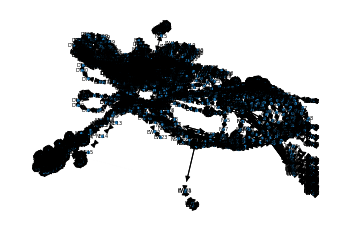

In [ ]:
for key, graph in graphs.items():
    pos = nx.kamada_kawai_layout(graph, scale=10)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=5)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=5, font_family="sans-serif")

    plt.axis("off")
    plt.figure(1, figsize=(500,1000))
    plt.savefig("graphs/" + key + ".png", dpi=500)